## MultiClass_Classification_Model

In [12]:
import pandas as pd
import numpy as np
import re
import urllib.parse
import html
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Define Attack Patterns

In [15]:
# SQL Injection patterns
sqli_patterns = [
    r"(?i)(\bUNION\b.*\bSELECT\b|\bSELECT\b.*\bUNION\b)",
    r"(?i)(1\s*=\s*1|0\s*=\s*0|\btrue\b|\bfalse\b)",
    r"(?i)(\'\s*=\s*\'|\"\s*=\s*\")",
    r"(--|\#|\/\*|\*\/)",
    r"(?i)\bexec(ute)?\s*[\(\s]",
    r"(?i)(char\(|ascii\(|substring\(|length\(|version\()",
    r"(?i)(waitfor\s+delay|benchmark\(|sleep\()",
    r"(?i)(extractvalue\(|updatexml\(|exp\()",
    r";\s*(drop|insert|update|delete|create|alter)",
    r"[\'\"][^\'\"]*[\'\"]",
    r"(?i)\bhaving\b.*\bcount\b",
    r"(?i)\border\s+by\b.*\d+"
]

# XSS patterns
xss_patterns = [
    r"(?i)<\s*script[^>]*>.*?</script>",
    r"(?i)<\s*script[^>]*>",
    r"(?i)on(load|error|click|mouseover|focus|blur|change|submit)\s*=",
    r"(?i)javascript\s*:",
    r"(?i)&\#(x)?[0-9a-f]+;",
    r"(?i)<\s*img[^>]*src\s*=\s*[\"']?javascript:",
    r"(?i)<\s*iframe[^>]*>",
    r"(?i)<\s*(object|embed)[^>]*>",
    r"(?i)(alert|confirm|prompt)\s*\(",
    r"(?i)document\.(write|writeln|cookie)",
    r"(?i)(expression\(|eval\()",
    r"(?i)<\s*meta[^>]*refresh"
]


#### Advanced Text Preprocessing

In [18]:
def preprocess_text(text):
    if pd.isna(text) or text == "":
        return ""
    decoded = text
    for _ in range(3):
        try:
            new_decoded = urllib.parse.unquote_plus(decoded)
            if new_decoded == decoded:
                break
            decoded = new_decoded
        except:
            break
    decoded = html.unescape(decoded)
    try:
        decoded = bytes(decoded, "utf-8").decode("unicode_escape")
    except:
        pass
    decoded = ' '.join(decoded.split()).lower()
    return decoded


#### Load Data and Handle Missing Values

In [21]:
file_path = "csic_database.csv"
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)

for col in ["Method", "URL", "content", "User-Agent"]:
    if col in df.columns:
        df[col] = df[col].fillna("")


Dataset shape: (61065, 17)


#### Extract Numerical Features and Assign Labels

In [24]:
# Prepare storage for features and labels
feature_list = []
attack_labels = []

for idx, row in df.iterrows():
    method = str(row["Method"])
    url = str(row["URL"])
    content = str(row["content"])
    ua = str(row["User-Agent"])
    combined = " ".join([preprocess_text(field) for field in [method, url, content, ua]])

    # Numerical features
    feats = {}
    feats["request_length"] = len(combined)
    feats["url_length"] = len(url)
    feats["content_length"] = len(content)
    feats["user_agent_length"] = len(ua)
    if combined:
        special_chars = '!@#$%^&*()[]{}|\\:";\'<>?,./`~'
        feats["special_char_ratio"] = sum(c in special_chars for c in combined) / len(combined)
        feats["digit_ratio"] = sum(c.isdigit() for c in combined) / len(combined)
        feats["alpha_ratio"] = sum(c.isalpha() for c in combined) / len(combined)
        feats["space_ratio"] = combined.count(" ") / len(combined)
        feats["quote_count"] = combined.count("'") + combined.count('"')
        feats["bracket_count"] = combined.count("<") + combined.count(">")
        feats["semicolon_count"] = combined.count(";")
        feats["equals_count"] = combined.count("=")
        feats["ampersand_count"] = combined.count("&")
    else:
        for key in ["special_char_ratio", "digit_ratio", "alpha_ratio", "space_ratio",
                    "quote_count", "bracket_count", "semicolon_count", "equals_count", "ampersand_count"]:
            feats[key] = 0

    feats["url_param_count"] = url.count("&") + url.count("=")
    feats["url_query_length"] = len(url.split("?")[-1]) if "?" in url else 0
    feats["url_path_depth"] = url.count("/")

    feats["sqli_pattern_score"] = sum(bool(re.search(p, combined)) for p in sqli_patterns)
    feats["xss_pattern_score"] = sum(bool(re.search(p, combined)) for p in xss_patterns)

    # Entropy
    if combined:
        counts = Counter(combined)
        total = len(combined)
        entropy = -sum((cnt / total) * np.log2(cnt / total) for cnt in counts.values())
        feats["entropy"] = entropy
    else:
        feats["entropy"] = 0

    # Append features
    feature_list.append(feats)

    # Attack type labeling
    if row.get("classification", 1) == 0:
        attack_labels.append(0)
    else:
        sqli_score = sum(len(re.findall(p, combined)) * 2 for p in sqli_patterns)
        xss_score = sum(len(re.findall(p, combined)) * 2 for p in xss_patterns)
        for kw in ["select", "union", "insert", "update", "delete", "drop", "exec", "char", "ascii", "substring", "concat"]:
            if kw in combined:
                sqli_score += 1
        for kw in ["script", "iframe", "object", "embed", "onload", "onclick", "onerror", "alert", "confirm", "prompt", "javascript"]:
            if kw in combined:
                xss_score += 1

        if sqli_score >= 3 and sqli_score > xss_score:
            attack_labels.append(1)
        elif xss_score >= 3 and xss_score > sqli_score:
            attack_labels.append(2)
        elif sqli_score >= 1 or xss_score >= 1:
            attack_labels.append(3)
        else:
            attack_labels.append(3)

# Convert features list to DataFrame
numerical_features_df = pd.DataFrame(feature_list)

print("Features extracted and labels assigned")



Features extracted and labels assigned


#### Create Text Matrix for Vectorization

In [26]:
combined_texts = []
for idx, row in df.iterrows():
    fields = [str(row["Method"]), str(row["URL"]), str(row["content"]), str(row["User-Agent"])]
    combined_texts.append(" ".join(preprocess_text(f) for f in fields))

#### Vectorize Text and Combine with Numerical Features

In [29]:
# Vectorizers
tfidf_char = TfidfVectorizer(analyzer="char_wb", ngram_range=(2,4), max_features=5000, min_df=2, max_df=0.95)
tfidf_word = TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_features=3000, min_df=2, max_df=0.95)
count_vec = CountVectorizer(analyzer="char", ngram_range=(3,5), max_features=2000, binary=True)

X_char = tfidf_char.fit_transform(combined_texts)
X_word = tfidf_word.fit_transform(combined_texts)
X_count = count_vec.fit_transform(combined_texts)

scaler = StandardScaler()
X_num = scaler.fit_transform(numerical_features_df.values)

X = hstack([X_char, X_word, X_count, X_num])
y = np.array(attack_labels)


#### Train-Test Split for Multiclass Classification (Normal vs SQLi vs XSS vs Others)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Define and Train Models

In [35]:
multiClass_models = {
    "XGBoost": xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="mlogloss"),
    "LightGBM": lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=2000, C=1.0, random_state=42, n_jobs=-1),
}

results = {}
for name, model in multiClass_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    results[name] = {"accuracy": acc, "f1": f1, "y_pred": y_pred}
    print(f"{name}: Accuracy={acc:.4f}, Weighted F1={f1:.4f}")


XGBoost: Accuracy=0.9849, Weighted F1=0.9848
LightGBM: Accuracy=0.9854, Weighted F1=0.9854
Random Forest: Accuracy=0.8774, Weighted F1=0.8799
Logistic Regression: Accuracy=0.9842, Weighted F1=0.9842


#### Classification Reports and Confusion Matrices


XGBoost Classification Report
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      7200
        SQLi       1.00      1.00      1.00       486
         XSS       1.00      1.00      1.00       301
       Other       1.00      0.96      0.98      4226

    accuracy                           0.98     12213
   macro avg       0.99      0.99      0.99     12213
weighted avg       0.99      0.98      0.98     12213



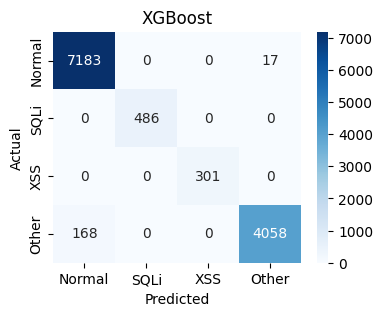


LightGBM Classification Report
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      7200
        SQLi       1.00      1.00      1.00       486
         XSS       1.00      1.00      1.00       301
       Other       0.99      0.96      0.98      4226

    accuracy                           0.99     12213
   macro avg       0.99      0.99      0.99     12213
weighted avg       0.99      0.99      0.99     12213



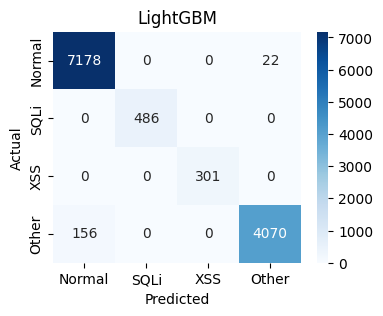


Random Forest Classification Report
              precision    recall  f1-score   support

      Normal       0.98      0.83      0.90      7200
        SQLi       1.00      0.78      0.87       486
         XSS       1.00      1.00      1.00       301
       Other       0.75      0.97      0.85      4226

    accuracy                           0.88     12213
   macro avg       0.93      0.89      0.90     12213
weighted avg       0.90      0.88      0.88     12213



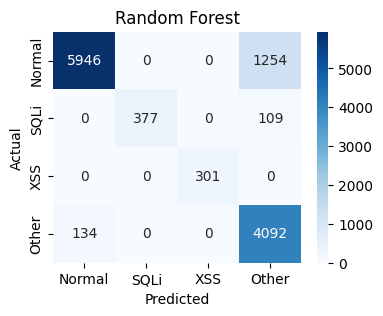


Logistic Regression Classification Report
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99      7200
        SQLi       1.00      1.00      1.00       486
         XSS       1.00      1.00      1.00       301
       Other       0.99      0.97      0.98      4226

    accuracy                           0.98     12213
   macro avg       0.99      0.99      0.99     12213
weighted avg       0.98      0.98      0.98     12213



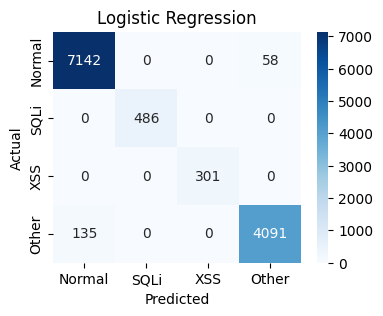

In [38]:
labels = ["Normal","SQLi","XSS","Other"]
for name, res in results.items():
    print(f"\n{name} Classification Report")
    print(classification_report(y_test, res["y_pred"], target_names=labels, zero_division=0))
    cm = confusion_matrix(y_test, res["y_pred"])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


#### Cross-Validation on Best Model

In [43]:
best_name = max(results, key=lambda x: results[x]["f1"])
best_model = multiClass_models[best_name]
print(f"Best Model: {best_name}")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring="f1_weighted", n_jobs=-1)
print(f"{best_name} 5-Fold Weighted F1: {cv_scores}")
print(f"Mean: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")


Best Model: LightGBM
LightGBM 5-Fold Weighted F1: [0.9860392  0.98594761 0.98727276 0.98545617 0.98413638]
Mean: 0.9858, Std: 0.0010


#### Final Performance Summary

In [46]:
perf = []
for name, res in results.items():
    perf.append({"Model": name, "Accuracy": res["accuracy"], "Weighted F1": res["f1"]})
perf_df = pd.DataFrame(perf).sort_values("Weighted F1", ascending=False)
print("Performance summary:")
display(perf_df)
print(f"Best model: {perf_df.iloc[0]['Model']} with Weighted F1 = {perf_df.iloc[0]['Weighted F1']:.4f}")

Performance summary:


,Model,Accuracy,Weighted F1
1,LightGBM,0.985425,0.985375
0,XGBoost,0.984852,0.984793
3,Logistic Regression,0.984197,0.984167
2,Random Forest,0.877426,0.879850


Best model: LightGBM with Weighted F1 = 0.9854
